In [15]:
import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

print("import succesfull")

import succesfull


In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/Uttam580/basic_ml/master/datasets./nyc_energy_consumption.csv')

In [17]:
df['timeStamp']= pd.to_datetime(df['timeStamp'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [19]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [20]:
fig = px.line(df, x = 'timeStamp',y = 'demand',title = 'NYC_Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [21]:
ny_df =df.set_index('timeStamp')

In [22]:
ny_df.head(2)

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf7f4aa240>,
      dtype=object)

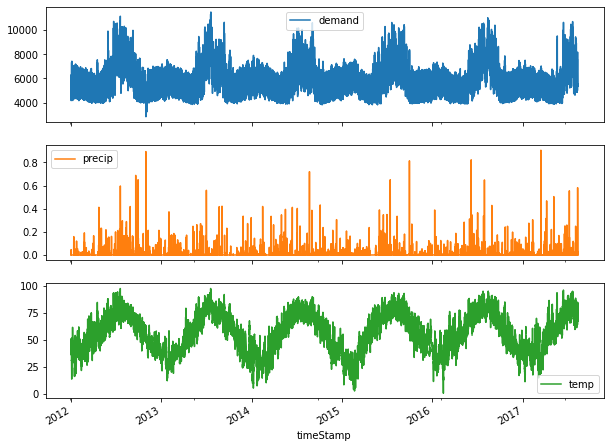

In [23]:
ny_df.plot(subplots = True)

In [24]:
ny_df.resample('D').mean()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf7ad65a20>,
      dtype=object)

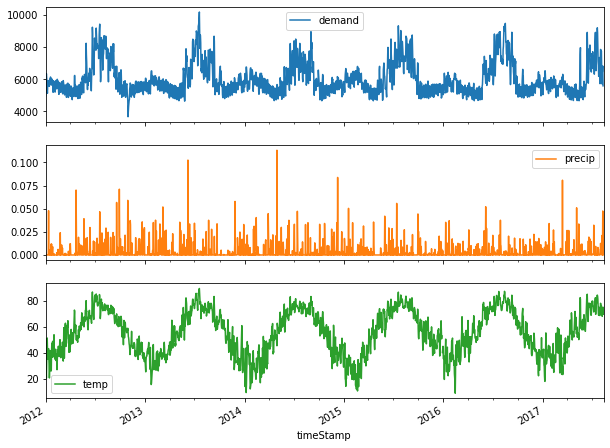

In [25]:
ny_df.resample('D').mean().plot(subplots=True)

In [26]:
ny_df_daily = ny_df.resample('D').mean()

In [27]:
ny_df_daily['demand']= ny_df_daily['demand'].fillna(method = 'ffill')
ny_df_daily['temp']= ny_df_daily['temp'].fillna(method = 'ffill')
ny_df_daily['precip']= ny_df_daily['precip'].fillna(method = 'ffill')

In [28]:
print(ny_df_daily)

                 demand    precip       temp
timeStamp                                   
2012-01-01  4954.833333  0.002487  46.510000
2012-01-02  5302.954167  0.000000  40.496667
2012-01-03  6095.512500  0.000000  26.672500
2012-01-04  6336.266667  0.000000  20.585000
2012-01-05  6130.245833  0.000000  33.577500
...                 ...       ...        ...
2017-08-08  6471.626042  0.000000  71.039167
2017-08-09  6811.112167  0.047529  73.852500
2017-08-10  5582.297000  0.002033  75.217500
2017-08-11  5582.297000  0.000000  72.767917
2017-08-12  5582.297000  0.000443  69.771429

[2051 rows x 3 columns]


In [29]:
from fbprophet import Prophet

In [30]:
ny_df_final = ny_df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')

In [31]:
ny_df_final.head(2)

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167


In [32]:
def printStats(dataframe):
  print("Rows     :", dataframe.shape[0])
  print("Columns  :", dataframe.shape[1])
  print("\n Features \n", dataframe.columns.to_list())
  print("\n Missing Values \n", dataframe.isnull().any())
  print("\n Unique Values \n", dataframe.nunique())

In [33]:
printStats(ny_df_final)

Rows     : 2051
Columns  : 2

 Features 
 ['ds', 'y']

 Missing Values 
 ds    False
y     False
dtype: bool

 Unique Values 
 ds    2051
y     2048
dtype: int64


In [34]:
train = ny_df_final[(ny_df_final['ds']>='2012-01-01') & (ny_df_final['ds']<='2017-04-30')]
test = ny_df_final[(ny_df_final['ds']>'2017-04-30')]

In [35]:
train.shape

(1947, 2)

In [36]:
test.shape


(104, 2)

In [37]:
m = Prophet(interval_width=0.95,yearly_seasonality=True) #confidence interval is 95%

In [38]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
m.params

OrderedDict([('k', array([[0.08888412]])),
             ('m', array([[0.59346583]])),
             ('delta',
              array([[ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01,
                      -2.11602996e-08,  1.40085597e-07,  1.81802026e-07,
                       1.43803423e-08, -6.11555343e-07,  6.49671582e-08,
                      -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
                      -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,
                       3.72434388e-07, -1.02857630e-06, -8.82474336e-02,
                      -3.95645665e-02, -1.56344720e-08,  5.48404650e-08,
                       6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
                       1.24238337e-07]])),
             ('sigma_obs', array([[0.04607601]])),
             ('beta',
              array([[-0.03458253, -0.07052008,  0.05760233,  0.04705168, -0.01407221,
                      -0.00500214, -0.00386595, -0.00073581,  0.00241974, -0.00755868,
                 

In [40]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [41]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7585.146506,6686.552014,8426.169282
2047,2017-08-09,7574.252310,6638.803429,8471.756423
2048,2017-08-10,7528.960519,6597.773350,8474.721670
2049,2017-08-11,7484.169113,6575.159491,8349.766142
2050,2017-08-12,6909.341600,5999.109441,7813.027338


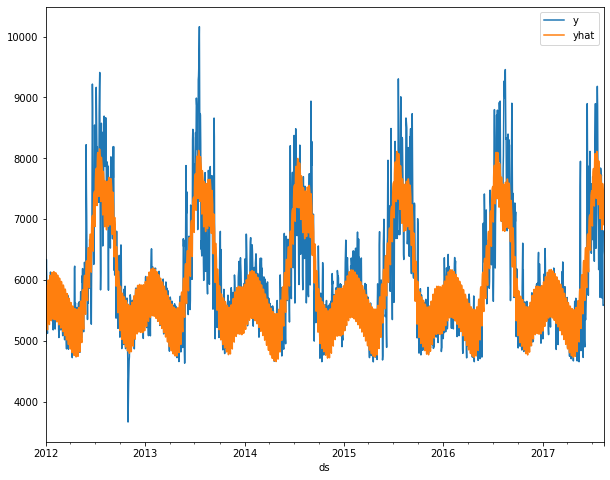

In [42]:
pd.concat([ny_df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

In [43]:
pd.concat([ny_df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).head(20)

,y,yhat
ds,,
2012-01-01,4954.833333,5101.495318
2012-01-02,5302.954167,5786.043206
2012-01-03,6095.512500,5903.236161
2012-01-04,6336.266667,5911.054104
2012-01-05,6130.245833,5881.804255
2012-01-06,5867.537500,5850.448280
2012-01-07,5177.441667,5286.574255
2012-01-08,5120.541667,5180.144895
2012-01-09,5890.820833,5867.678824


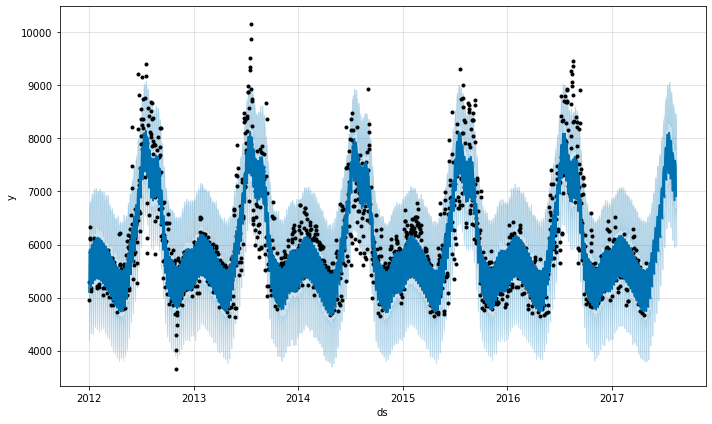

In [44]:
fig1 = m.plot(forecast)
#95% Confidence interval is the light blue color
#the black dots are actual values 
#the dark blue is the y_hat or forecasted value

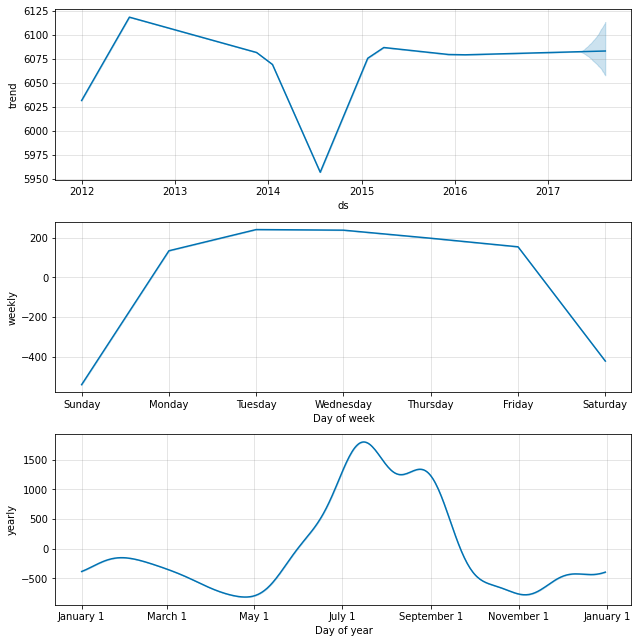

In [45]:
fig2 = m.plot_components(forecast)

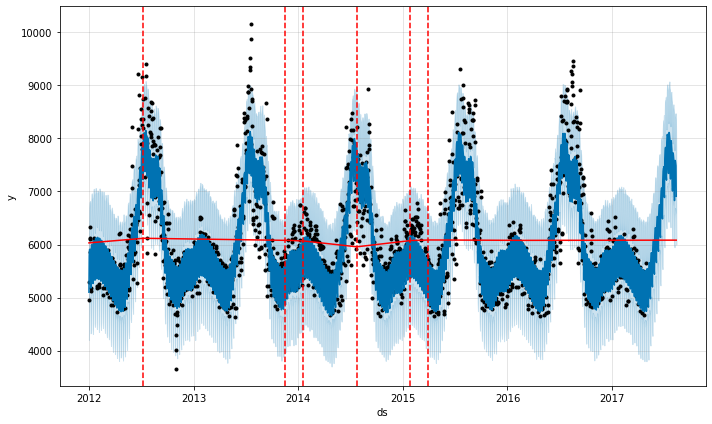

In [46]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

In [47]:
deltas = m.params['delta'].mean(0)
deltas

array([ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01, -2.11602996e-08,
        1.40085597e-07,  1.81802026e-07,  1.43803423e-08, -6.11555343e-07,
        6.49671582e-08, -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
       -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,  3.72434388e-07,
       -1.02857630e-06, -8.82474336e-02, -3.95645665e-02, -1.56344720e-08,
        5.48404650e-08,  6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
        1.24238337e-07])

In [48]:
range(len(deltas))

range(0, 25)

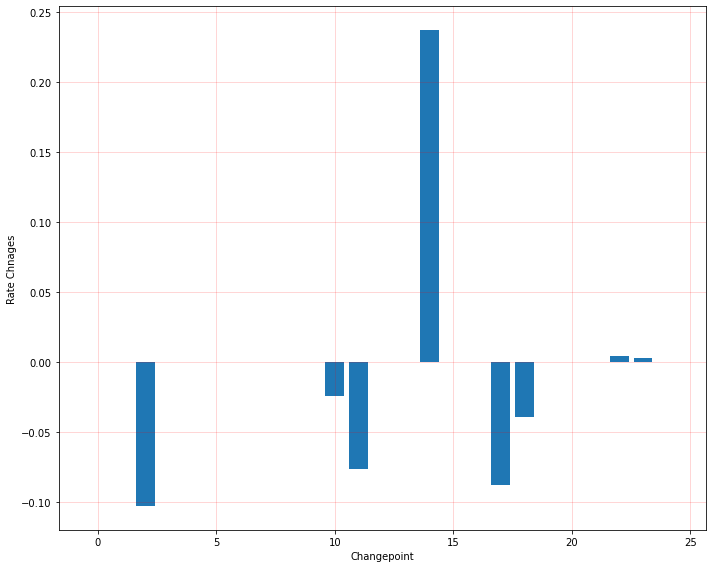

In [49]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True,which='major',c='red',ls='-',alpha=0.2)
ax.set_ylabel('Rate Chnages')
ax.set_xlabel('Changepoint')
fig.tight_layout()
#Prophet plots around 25 chnage points

In [50]:
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


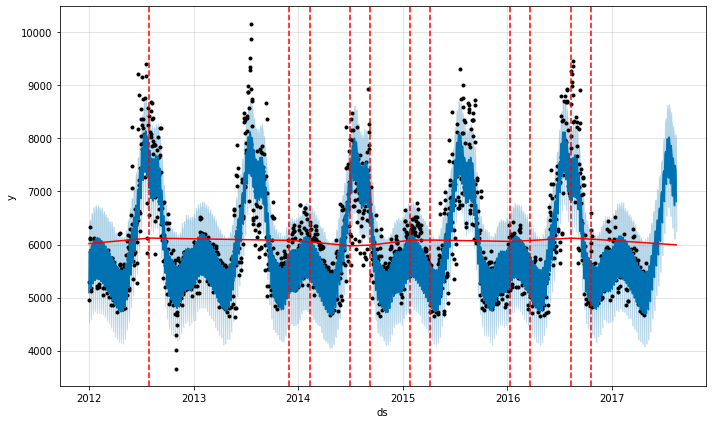

In [51]:
pro_change = Prophet(changepoint_range=0.9,yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_change,forecast)

In [52]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m,forecast) #this returns the plotly figure
py.iplot(fig)

In [53]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model = m,initial = '731 days',horizon='365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [54]:
cv_results.head(5)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5560.399158,4723.969890,6402.925465,5460.325000,2014-05-01
1,2014-05-03,4970.368653,4167.700683,5857.997954,4893.683333,2014-05-01
2,2014-05-04,4846.526492,4043.971455,5625.633108,4764.137500,2014-05-01
3,2014-05-05,5527.405000,4658.797398,6348.185981,5406.762500,2014-05-01
4,2014-05-06,5622.303858,4761.527890,6496.391710,5409.750000,2014-05-01


In [55]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,251429.065746,501.427029,405.741907,0.072931,0.065579,0.890110
1,37 days 00:00:00,258154.308609,508.088879,413.132705,0.074218,0.066087,0.884615
2,37 days 12:00:00,260458.355734,510.351208,416.504551,0.074798,0.066775,0.884615
3,38 days 00:00:00,263245.456254,513.074513,419.608202,0.075062,0.067182,0.879121
4,38 days 12:00:00,266934.102525,516.656658,424.824052,0.075894,0.067543,0.879121
...,...,...,...,...,...,...,...
653,363 days 00:00:00,260005.135786,509.906987,446.400124,0.082383,0.081701,0.983516
654,363 days 12:00:00,261690.499217,511.556936,447.442090,0.082567,0.082034,0.983516
655,364 days 00:00:00,266012.437438,515.763936,450.969835,0.083405,0.082787,0.983516
656,364 days 12:00:00,266053.564909,515.803805,450.639292,0.083380,0.082787,0.983516
